In [9]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
from scipy.stats import linregress
import os
import glob
from sklearn.metrics import r2_score

import matplotlib
pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [10]:
def curve_to_fit(lsts, gain, offset):
    '''
    Define curve to fit data to
    offset is Tsys offset from zero = Trxr + g * <Tsky>
    '''
    global interp_values
    return (gain * interp_values + offset)

def gain_rxr_temp(auto_fits, covs, save_npz = True, file_name = 'rxr_temp_w_err'):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    
    A_0 = auto_fits[:, :, :, 0]
    R_0 = auto_fits[:, :, :, 1]
    
    gains = A_0
    
    rxr_temp = R_0 / A_0 - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * R_0**2 / A_0**4  + 
                           covs[:,:,:,1,1] * 1.0 / A_0**2 - 
                           2 * covs[:,:,:,0,1] * R_0 / A_0**3)
    if save_npz:
        np.savez(file_name, gains=gains, rxr_temp_err=rxr_temp_err, 
                            rxr_temp=rxr_temp, auto_fits=auto_fits,
                            covs=covs)
        
    return gains, rxr_temp, rxr_temp_err

# Raise/Lower the Sidelobes

In [15]:
JD = 2458098

Tsky_files = glob.glob('/Users/tyler/Folders/Research/HERA/Tsys/sky_models/HERA_Tsky*lobes*')
Tsky_files.append('/Users/tyler/Folders/Research/HERA/Tsys/data/HERA_Tsky_nic_beam.npz')
Tsky_files.sort()

data = np.load('/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Folders/Research/HERA/Tsys/data/IDR2_{}_autos.npz'.format(JD)
autos = np.load(autos_file)
data_lsts = autos['lsts']
data_ave = autos['data_ave']

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

In [16]:
# Fit auto data to model
gains = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp_err = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
auto_fits_run = np.zeros((len(Tsky_files), npol, nant, len(freqs),2))
rerun_fit = False

for si, sf in enumerate(Tsky_files):
    
    data = np.load(sf)
    freqs = data['freqs']  # These are already made to fit the data
    model_lsts = data['lsts']
    model_HERA_Tsky = data['HERA_Tsky']

    # Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
    interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
    interp_Tsky_array = interp_Tsky(data_lsts[0])
    Tsky_mean = np.mean(interp_Tsky_array, axis=2)
    Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)
    
    auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
    covs = np.zeros((npol, nant, len(freqs), 2, 2))
    fits_file = sf.split('/')[-1].split('.')[0] + '_fits'
    print fits_file
    file_name = '/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/{JD}/{f}.npz'.format(JD=JD, f = fits_file)
    
    if os.path.exists(file_name) and not rerun_fit:
        fits_data = np.load(file_name)
        gains[si, :, :, :] = fits_data['gains']
        rxr_temp_err[si, :, :, :] = fits_data['rxr_temp_err']
        rxr_temp[si, :, :, :] = fits_data['rxr_temp']
        auto_fits_run[si, :, :, :, 0] = gains[si,:,:,:]
        auto_fits_run[si, :, :, :, 1] = (rxr_temp[si,:,:,:] + Tsky_mean[:, None, :])*gains[si,:,:,:]

    else:
        for pol in xrange(npol):
            for fi, freq in enumerate(freqs):
                interp_values = Tsky_prime[pol, fi, :]
                for anti, ant in enumerate(HERA_list):
                    out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi],
                                    bounds=(0, np.inf), absolute_sigma=True)
                    auto_fits[pol, anti, fi, :] = out[0]
                    covs[pol, anti, fi, :, :] = out[1]
        g, rt, rt_err = gain_rxr_temp(auto_fits, covs, save_npz=True, file_name=file_name)
        gains[si, :, :, :] = g
        rxr_temp[si, :, :, :] = rt
        rxr_temp_err[si, :, :, :] = rt_err
        

HERA_Tsky_nic_beam_fits
HERA_Tsky_lower_lobes_10_percent_fits
HERA_Tsky_lower_lobes_15_percent_fits
HERA_Tsky_lower_lobes_20_percent_fits
HERA_Tsky_lower_lobes_25_percent_fits
HERA_Tsky_raise_lobes_10_percent_fits
HERA_Tsky_raise_lobes_15_percent_fits
HERA_Tsky_raise_lobes_20_percent_fits
HERA_Tsky_raise_lobes_25_percent_fits


## Weighted Average of the Receiver Temperature Across Antenna

In [17]:
avg_temps = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))
avg_err = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))

for si in np.arange(len(Tsky_files)):
    for poli, pol in enumerate(pols):
        for i in np.arange(rxr_temp.shape[3]):
            avg_temps[si, poli, i] = np.average(rxr_temp[si, poli,:,i], weights=1.0/rxr_temp_err[si, poli,:,i]**2)
            avg_err[si, poli, i] = np.sqrt(1.0 / np.sum(rxr_temp_err[si, poli,:,i]**(-2)))
            

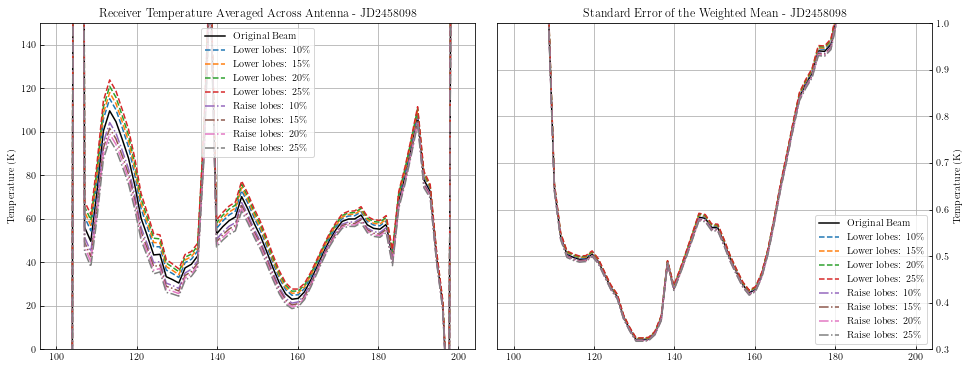

In [20]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for si, sf in enumerate(Tsky_files):
    poli = 0
    label = sf.split('_')
    
    for poli, pol in enumerate(['X']): 
        
        if label[-4] == 'lower':
            ls = '--'
            legend = '{OPP} lobes: {perc}\%'.format(OPP=str.capitalize(label[-4]), perc=label[-2])
        elif label[-4] == 'raise':
            ls = '-.'
            legend = '{OPP} lobes: {perc}\%'.format(OPP=str.capitalize(label[-4]), perc=label[-2])
        else:
            ls = 'k'
            legend = 'Original Beam'
            
        axarr[0].plot(freqs, avg_temps[si, poli,:], ls,label=legend)      
        axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
        axarr[0].set_ylim([0,150])
        axarr[0].set_ylabel('Temperature (K)')
        axarr[1].set_ylabel('Temperature (K)')
        axarr[1].plot(freqs, avg_err[si, poli,:], ls, label=legend) 
        axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
        axarr[1].yaxis.tick_right()
        axarr[1].yaxis.set_label_position("right")
        axarr[1].set_ylim([0.3,1])
        axarr[0].legend()
        axarr[1].legend()
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.show()
plt.savefig('/Users/tyler/Downloads/avg_temp_w_err_{JD}.png'.format(JD=JD), bbox_inches='tight', dpi=200)

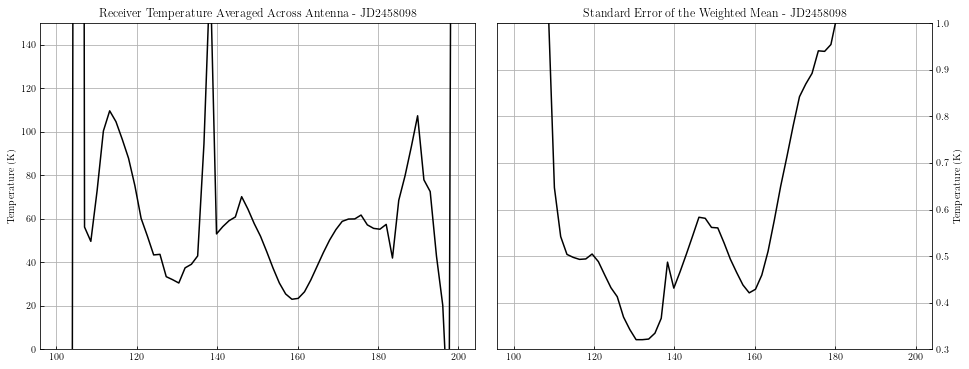

In [27]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

si = 0
ls = 'k'

for poli, pol in enumerate(['X']):             
    axarr[0].plot(freqs, avg_temps[si, poli,:], ls,label=legend)      
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
    axarr[0].set_ylim([0,150])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[si, poli,:], ls, label=legend) 
    axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1])

axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.show()
plt.savefig('/Users/tyler/Downloads/single_avg_temp_w_err_{JD}.png'.format(JD=JD), bbox_inches='tight', dpi=200)

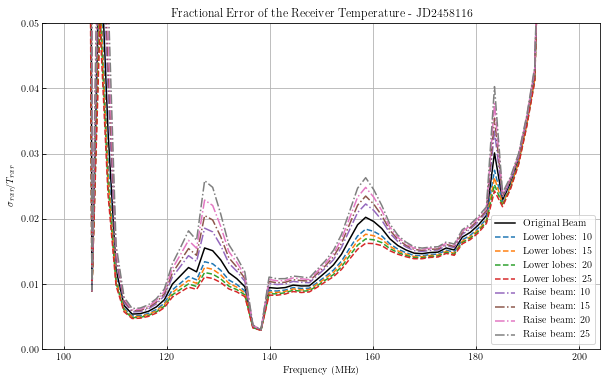

In [8]:
plt.figure(figsize=(10,6))

poli = 1

for si, sf in enumerate(Tsky_files):
    label = sf.split('_')
    if label[-4] == 'lower':
            ls = '--'
            legend = '{OPP} lobes: {perc}%'.format(OPP=str.capitalize(label[-4]), perc=label[-2])
    elif label[-4] == 'raise':
        ls = '-.'
        legend = '{OPP} beam: {perc}%'.format(OPP=str.capitalize(label[-4]), perc=label[-2])
    else:
        ls = 'k'
        legend = 'Original Beam'
            
    plt.plot(freqs, avg_err[si,poli,:] / np.abs(avg_temps[si,poli,:]), ls, label=legend)
    #plt.plot(freqs, avg_err[si,1,:] / np.abs(avg_temps[si,1,:]), label=str(si+1) + 'deg - YY')
    plt.ylim([0,0.05])
    plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(JD))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    plt.legend()
    plt.grid()
plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

## Effect of the Uncertainty in the Sidelobe Size on the Fits

In [9]:
tot_err = np.zeros((2, len(HERA_list), len(freqs)))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        tot_err[poli, anti, :] = np.std(rxr_temp[:, poli, anti, :], axis = 0) + rxr_temp_err[0, poli, anti, :]

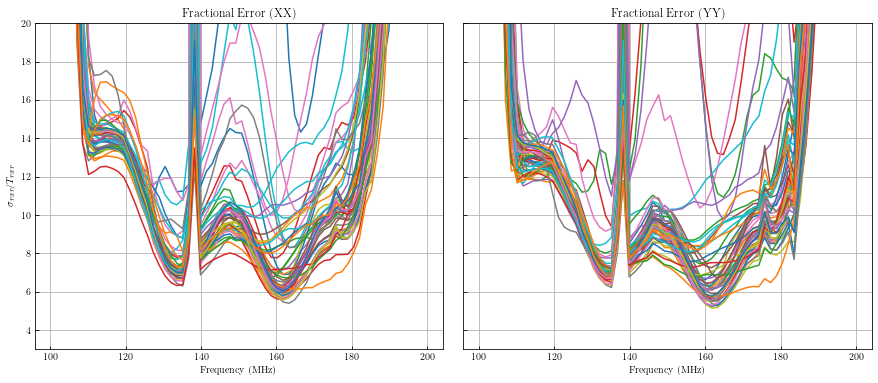

In [10]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, tot_err[poli, anti], label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([3,20])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)

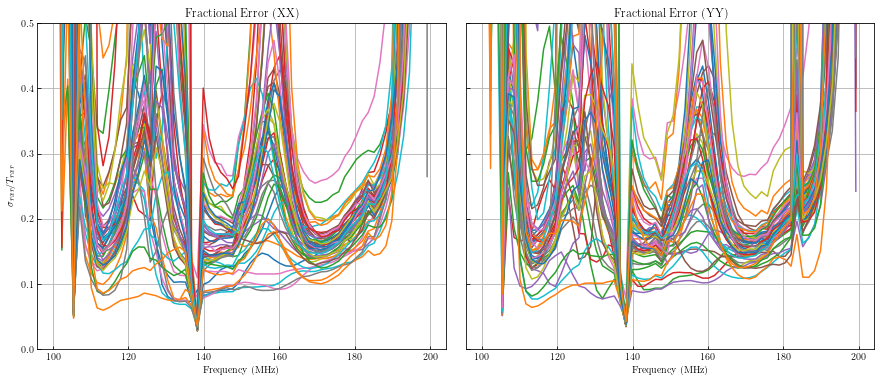

In [11]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, tot_err[poli, anti] / np.abs(rxr_temp[0, poli, anti, :]), label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.5])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)

# Widen/Narrow the Beam

In [12]:
Tsky_files = glob.glob('/Users/tyler/Folders/Research/HERA/Tsys/sky_models/HERA_Tsky_narrow_*')
Tsky_files.append('/Users/tyler/Folders/Research/HERA/Tsys/data/HERA_Tsky_nic_beam.npz')
Tsky_files += glob.glob('/Users/tyler/Folders/Research/HERA/Tsys/sky_models/HERA_Tsky_wide_*')
Tsky_files.sort()

In [13]:
# Fit auto data to model
gains = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
rxr_temp_err = np.zeros((len(Tsky_files), npol, nant, len(freqs)))
auto_fits_run = np.zeros((len(Tsky_files), npol, nant, len(freqs),2))
rerun_fit = False

for si, sf in enumerate(Tsky_files):
    
    data = np.load(sf)
    freqs = data['freqs']  # These are already made to fit the data
    model_lsts = data['lsts']
    model_HERA_Tsky = data['HERA_Tsky']

    # Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
    interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
    interp_Tsky_array = interp_Tsky(data_lsts[0])
    Tsky_mean = np.mean(interp_Tsky_array, axis=2)
    Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)
    
    auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
    covs = np.zeros((npol, nant, len(freqs), 2, 2))
    fits_file = sf.split('/')[-1].split('.')[0] + '_fits'
    print fits_file
    file_name = '/Users/tyler/Folders/Research/HERA/Tsys/Tsys_plots/IDR2/{JD}/{f}.npz'.format(JD=JD, f = fits_file)
    
    if os.path.exists(file_name) and not rerun_fit:
        fits_data = np.load(file_name)
        gains[si, :, :, :] = fits_data['gains']
        rxr_temp_err[si, :, :, :] = fits_data['rxr_temp_err']
        rxr_temp[si, :, :, :] = fits_data['rxr_temp']
        auto_fits_run[si, :, :, :, 0] = gains[si,:,:,:]
        auto_fits_run[si, :, :, :, 1] = (rxr_temp[si,:,:,:] + Tsky_mean[:, None, :])*gains[si,:,:,:]

    else:
        for pol in xrange(npol):
            for fi, freq in enumerate(freqs):
                interp_values = Tsky_prime[pol, fi, :]
                for anti, ant in enumerate(HERA_list):
                    out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][ant, :, fi],
                                    bounds=(0, np.inf), absolute_sigma=True)
                    auto_fits[pol, anti, fi, :] = out[0]
                    covs[pol, anti, fi, :, :] = out[1]
        g, rt, rt_err = gain_rxr_temp(auto_fits, covs, save_npz=True, file_name=file_name)
        gains[si, :, :, :] = g
        rxr_temp[si, :, :, :] = rt
        rxr_temp_err[si, :, :, :] = rt_err
        

HERA_Tsky_nic_beam_fits
HERA_Tsky_narrow_10_percent_fits
HERA_Tsky_narrow_15_percent_fits
HERA_Tsky_narrow_20_percent_fits
HERA_Tsky_narrow_25_percent_fits
HERA_Tsky_wide_10_percent_fits
HERA_Tsky_wide_15_percent_fits
HERA_Tsky_wide_20_percent_fits
HERA_Tsky_wide_25_percent_fits


In [14]:
avg_temps = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))
avg_err = np.zeros((len(Tsky_files), 2, rxr_temp.shape[3]))

for si in np.arange(len(Tsky_files)):
    for poli, pol in enumerate(pols):
        for i in np.arange(rxr_temp.shape[3]):
            avg_temps[si, poli, i] = np.average(rxr_temp[si, poli,:,i], weights=1.0/rxr_temp_err[si, poli,:,i]**2)
            avg_err[si, poli, i] = np.sqrt(1.0 / np.sum(rxr_temp_err[si, poli,:,i]**(-2)))
            

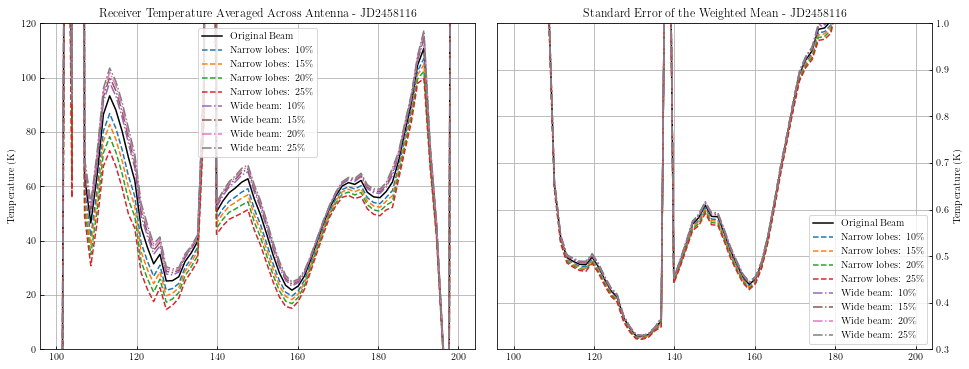

In [17]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for si, sf in enumerate(Tsky_files):
    poli = 0
    label = sf.split('_')
    
    for poli, pol in enumerate(['X']): 
        
        if label[-3] == 'narrow':
            ls = '--'
            legend = '{OPP} lobes: {perc}\%'.format(OPP=str.capitalize(label[-3]), perc=label[-2])
        elif label[-3] == 'wide':
            ls = '-.'
            legend = '{OPP} beam: {perc}\%'.format(OPP=str.capitalize(label[-3]), perc=label[-2])
        else:
            ls = 'k'
            legend = 'Original Beam'
            
        axarr[0].plot(freqs, avg_temps[si, poli,:], ls,label=legend)      
        axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
        axarr[0].set_ylim([0,120])
        axarr[0].set_ylabel('Temperature (K)')
        axarr[1].set_ylabel('Temperature (K)')
        axarr[1].plot(freqs, avg_err[si, poli,:], ls, label=legend) 
        axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
        axarr[1].yaxis.tick_right()
        axarr[1].yaxis.set_label_position("right")
        axarr[1].set_ylim([0.3,1])
        axarr[0].legend()
        axarr[1].legend()
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_temp_w_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

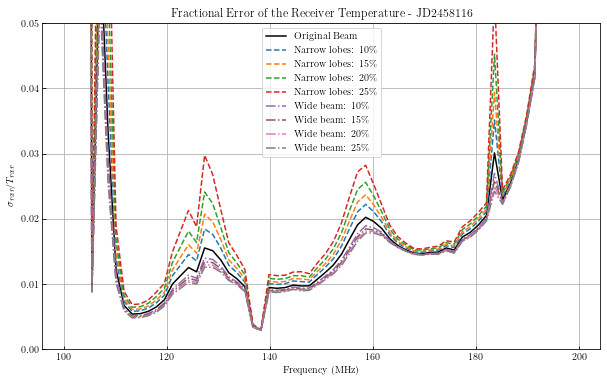

In [18]:
plt.figure(figsize=(10,6))

poli = 1

for si, sf in enumerate(Tsky_files):
    label = sf.split('_')
    if label[-3] == 'narrow':
            ls = '--'
            legend = '{OPP} lobes: {perc}\%'.format(OPP=str.capitalize(label[-3]), perc=label[-2])
    elif label[-3] == 'wide':
        ls = '-.'
        legend = '{OPP} beam: {perc}\%'.format(OPP=str.capitalize(label[-3]), perc=label[-2])
    else:
        ls = 'k'
        legend = 'Original Beam'

    plt.plot(freqs, avg_err[si,poli,:] / np.abs(avg_temps[si,poli,:]), ls, label=legend)
    #plt.plot(freqs, avg_err[si,1,:] / np.abs(avg_temps[si,1,:]), label=str(si+1) + 'deg - YY')
    plt.ylim([0,0.05])
    plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(JD))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    plt.legend()
    plt.grid()
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

In [19]:
tot_err = np.zeros((2, len(HERA_list), len(freqs)))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        tot_err[poli, anti, :] = np.std(rxr_temp[:, poli, anti, :], axis = 0) + rxr_temp_err[0, poli, anti, :]

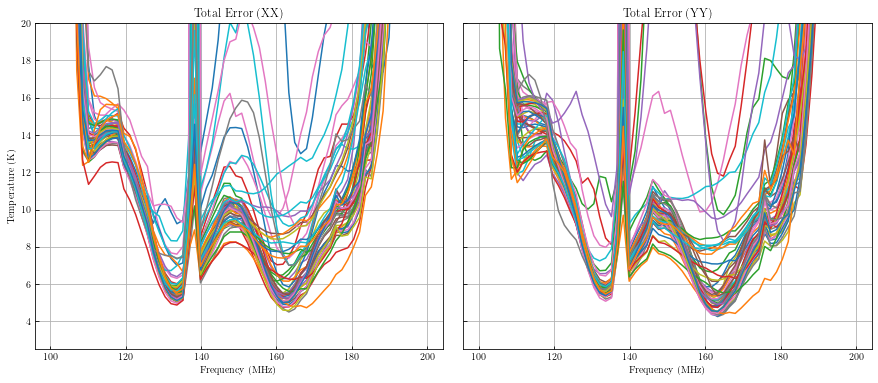

In [20]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, tot_err[poli, anti], label=str(ant))
    axarr[poli].set_title('Total Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'Temperature (K)')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([2.5,20])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)

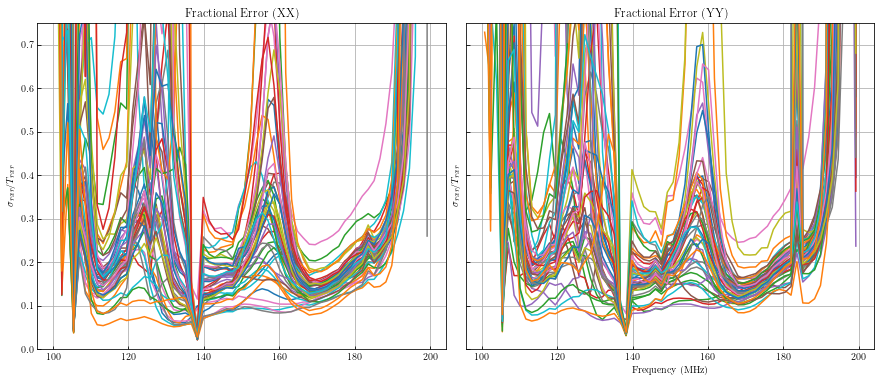

In [22]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, tot_err[poli, anti] / np.abs(rxr_temp[0, poli, anti, :]), label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[1].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.75])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05, hspace=0.25)